This solution is a stack and blend of three models(CatBoost, XGBoost and LGBM).

### **IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb

import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
import random
warnings.filterwarnings("ignore")
warnings.simplefilter(action= 'ignore', category= FutureWarning)
pd.set_option('display.max_columns', 200)

### **SPECIAL FUNCTION**

In this class, 

variable "val_p"  is where all the predictions based on the validation set from each cross validation loop is stored 


variable "test_p" is where the test set predictions are stored.


predictions are based on the whole training data itself. 


"val_p1" and test_p1 is for catboost

"val_p2" and test_p2 is for xgboost

"val_p3" and test_p3 is for lgbm



In [2]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
            
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model
    
    
    
    # reference: (maxprop) 1st place solution DSN pre-boothcamp Hackathon (Expresso Churn)

## **DATA IMPORT **

In [133]:
train = pd.read_csv("C:/Users/user/Desktop/1.coding_datascience/70 days machine learning/boothcamp qualification/Train.csv")
test = pd.read_csv("C:/Users/user/Desktop/1.coding_datascience/70 days machine learning/boothcamp qualification/Test.csv")
submission = pd.read_csv("C:/Users/user/Desktop/1.coding_datascience/70 days machine learning/boothcamp qualification/SampleSubmission.csv")


## **EXPLORATORY DATA ANALYSIS **

In [35]:
sum(test.isnull().values.ravel())

225629

In [36]:
 sum([True for idx,row in test.iterrows() if any(row.isnull())])


23919

In [44]:
test.apply(lambda x: sum(x.isnull().values), axis = 1)

0        10
1         6
3         8
4         3
6         4
         ..
23993    13
23994     3
23996     5
23998     4
23999    10
Length: 19932, dtype: int64

In [48]:
(test.apply(lambda x: sum(x.isnull().values), axis = 1)>9)

0         True
1        False
3        False
4        False
6        False
         ...  
23993     True
23994    False
23996    False
23998    False
23999     True
Length: 19932, dtype: bool

In [33]:
test.isnull().sum(axis = 1)

0        10
1         6
2        32
3         8
4         3
         ..
23995    18
23996     5
23997    19
23998     4
23999    10
Length: 24000, dtype: int64

## **FEATURE ENGINEERING **

In [134]:
# change categorical data to numerical data in form_field 47 and in default_status 
# set type as float

train['default_status'] = train['default_status'].map({'no':0, 'yes':1}).astype(np.float)
train['form_field47'] = train['form_field47'].map({'charge':0, 'lending':1}).astype(np.float)
test['form_field47'] = test['form_field47'].map({'charge':0, 'lending':1}).astype(np.float)

# convert form_field 14 to float

train['form_field14'] = train['form_field14'].astype(np.float)
test['form_field14'] = test['form_field14'].astype(np.float)


# form_field 28  is Number of days since last missed payment on any credit line
# some values are less than 1, so i converted them to hours by multiplying by 24

train['form_field28'] = train['form_field28']* 24.0
test['form_field28'] = test['form_field28']* 24.0




In [136]:
# drop undefined variables  (48 49)

train.drop(columns=['form_field48', 'form_field49'], inplace=True)
test.drop(columns=['form_field48', 'form_field49'], inplace=True)

# drop Applicant_ID

train.drop(['Applicant_ID'], 1, inplace = True)
test.drop(['Applicant_ID'], 1, inplace = True)

In [139]:
# change all time features in days to years by dividing by 365

for i in ['form_field25','form_field26','form_field27','form_field28', 'form_field29', 'form_field30', 'form_field31']:
    data[i] = data[i]/365
    

# change all time features in months to years by dividing by 12    
for i in ['form_field32', 'form_field33']:
    data[i] = data[i]/12

    
# multiply all the percentage features by 100

for i in ['form_field21','form_field22','form_field23','form_field24', 'form_field40', 'form_field41']:
    data[i] = data[i] * 100

# multiply form_field 44 by form_field 12

data['max_amount'] = data['form_field44'] * data['form_field12']
data['min_amount'] = data['form_field50'] * data['form_field12']

# maximum amount divided by the minimum amount
data['max/min_amount'] = data['form_field44'] / data['form_field50']

In [137]:
# concatenate train and test

ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [138]:
# group by formfield_47 (because form field 1, 2, 6 and 47 are really doing well on the features importance plot.) 

region = data.groupby('form_field47',).mean()
region.drop('default_status', 1, inplace = True)
cols = []
for i in region.columns:
    if i != 'form_field47':
        region[i+'_reg_mean_all'] = region[i]
        region.drop(i, 1, inplace = True)
        cols.append(i+'_reg_mean_all')

data = pd.merge(data, region, on='form_field47', how = 'left')
for col in cols: data[col+'_freq'] = data[col].map(data[col].value_counts().to_dict())/len(data)

## **EXTRACT TARGET, TRAINING DATA AND TEST DATA  **

In [140]:
train = data[:ntrain].copy()
target = train.default_status.copy()
train.drop('default_status', axis=1, inplace=True)

test = data[ntrain:].copy()
test.drop('default_status', axis=1, inplace=True)
test = test.reset_index(drop=True)

In [141]:
train.dtypes

form_field1                       float64
form_field10                      float64
form_field11                      float64
form_field12                      float64
form_field13                      float64
                                   ...   
form_field50_reg_mean_all_freq    float64
form_field6_reg_mean_all_freq     float64
form_field7_reg_mean_all_freq     float64
form_field8_reg_mean_all_freq     float64
form_field9_reg_mean_all_freq     float64
Length: 142, dtype: object

In [142]:
test.columns.sort_values()

Index(['form_field1', 'form_field10', 'form_field10_reg_mean_all',
       'form_field10_reg_mean_all_freq', 'form_field11',
       'form_field11_reg_mean_all', 'form_field11_reg_mean_all_freq',
       'form_field12', 'form_field12_reg_mean_all',
       'form_field12_reg_mean_all_freq',
       ...
       'form_field6_reg_mean_all_freq', 'form_field7',
       'form_field7_reg_mean_all', 'form_field7_reg_mean_all_freq',
       'form_field8', 'form_field8_reg_mean_all',
       'form_field8_reg_mean_all_freq', 'form_field9',
       'form_field9_reg_mean_all', 'form_field9_reg_mean_all_freq'],
      dtype='object', length=142)

## **MODEL 1 - CATBOOST **

================================Fold1====================================
0:	test: 0.7724121	best: 0.7724121 (0)	total: 72ms	remaining: 12m
50:	test: 0.8338557	best: 0.8338557 (50)	total: 2.89s	remaining: 9m 23s
100:	test: 0.8369463	best: 0.8369832 (99)	total: 5.7s	remaining: 9m 18s
150:	test: 0.8385357	best: 0.8385357 (150)	total: 8.36s	remaining: 9m 5s
200:	test: 0.8393004	best: 0.8393004 (200)	total: 11s	remaining: 8m 57s
250:	test: 0.8399517	best: 0.8399630 (249)	total: 14s	remaining: 9m 4s
300:	test: 0.8403819	best: 0.8403819 (300)	total: 16.7s	remaining: 8m 58s
350:	test: 0.8408993	best: 0.8408993 (350)	total: 19.3s	remaining: 8m 50s
400:	test: 0.8415176	best: 0.8415176 (400)	total: 21.9s	remaining: 8m 43s
450:	test: 0.8417953	best: 0.8417953 (450)	total: 24.7s	remaining: 8m 43s
500:	test: 0.8419505	best: 0.8419628 (492)	total: 28s	remaining: 8m 50s
550:	test: 0.8422405	best: 0.8422452 (548)	total: 32.4s	remaining: 9m 16s
600:	test: 0.8423789	best: 0.8423807 (599)	total: 35.5s	re

1200:	test: 0.8418715	best: 0.8419172 (1022)	total: 1m 6s	remaining: 8m 8s
1250:	test: 0.8419111	best: 0.8419172 (1022)	total: 1m 9s	remaining: 8m 5s
1300:	test: 0.8418654	best: 0.8419255 (1264)	total: 1m 12s	remaining: 8m 3s
1350:	test: 0.8419146	best: 0.8419255 (1264)	total: 1m 14s	remaining: 7m 58s
1400:	test: 0.8418944	best: 0.8419384 (1356)	total: 1m 17s	remaining: 7m 55s
1450:	test: 0.8418789	best: 0.8419384 (1356)	total: 1m 20s	remaining: 7m 51s
1500:	test: 0.8419238	best: 0.8419384 (1356)	total: 1m 22s	remaining: 7m 47s
1550:	test: 0.8420273	best: 0.8420423 (1547)	total: 1m 25s	remaining: 7m 45s
1600:	test: 0.8419424	best: 0.8420423 (1547)	total: 1m 28s	remaining: 7m 42s
1650:	test: 0.8419958	best: 0.8420423 (1547)	total: 1m 30s	remaining: 7m 39s
1700:	test: 0.8420048	best: 0.8420728 (1684)	total: 1m 33s	remaining: 7m 35s
1750:	test: 0.8419593	best: 0.8420728 (1684)	total: 1m 35s	remaining: 7m 32s
1800:	test: 0.8419657	best: 0.8420728 (1684)	total: 1m 38s	remaining: 7m 28s
1850

2300:	test: 0.8325259	best: 0.8325430 (2288)	total: 2m 3s	remaining: 6m 54s
2350:	test: 0.8325068	best: 0.8325430 (2288)	total: 2m 6s	remaining: 6m 51s
2400:	test: 0.8325471	best: 0.8325547 (2388)	total: 2m 9s	remaining: 6m 48s
2450:	test: 0.8325416	best: 0.8325547 (2388)	total: 2m 11s	remaining: 6m 45s
2500:	test: 0.8326110	best: 0.8326178 (2474)	total: 2m 13s	remaining: 6m 41s
2550:	test: 0.8326516	best: 0.8326643 (2534)	total: 2m 16s	remaining: 6m 38s
2600:	test: 0.8326678	best: 0.8326961 (2580)	total: 2m 18s	remaining: 6m 35s
2650:	test: 0.8326837	best: 0.8326961 (2580)	total: 2m 21s	remaining: 6m 32s
2700:	test: 0.8327020	best: 0.8327020 (2700)	total: 2m 23s	remaining: 6m 28s
2750:	test: 0.8326838	best: 0.8327175 (2738)	total: 2m 26s	remaining: 6m 25s
2800:	test: 0.8326999	best: 0.8327175 (2738)	total: 2m 28s	remaining: 6m 21s
2850:	test: 0.8327469	best: 0.8327591 (2843)	total: 2m 31s	remaining: 6m 18s
2900:	test: 0.8328320	best: 0.8328346 (2897)	total: 2m 33s	remaining: 6m 15s
29

3150:	test: 0.8447947	best: 0.8448332 (2893)	total: 2m 43s	remaining: 5m 56s
3200:	test: 0.8447882	best: 0.8448332 (2893)	total: 2m 46s	remaining: 5m 53s
3250:	test: 0.8447917	best: 0.8448332 (2893)	total: 2m 49s	remaining: 5m 51s
3300:	test: 0.8448307	best: 0.8448332 (2893)	total: 2m 51s	remaining: 5m 48s
3350:	test: 0.8448254	best: 0.8448486 (3306)	total: 2m 54s	remaining: 5m 45s
3400:	test: 0.8447855	best: 0.8448486 (3306)	total: 2m 56s	remaining: 5m 42s
3450:	test: 0.8447405	best: 0.8448486 (3306)	total: 2m 59s	remaining: 5m 39s
3500:	test: 0.8448423	best: 0.8448486 (3306)	total: 3m 1s	remaining: 5m 37s
3550:	test: 0.8447528	best: 0.8448486 (3306)	total: 3m 4s	remaining: 5m 35s
3600:	test: 0.8447360	best: 0.8448486 (3306)	total: 3m 7s	remaining: 5m 32s
3650:	test: 0.8447261	best: 0.8448486 (3306)	total: 3m 9s	remaining: 5m 29s
3700:	test: 0.8447686	best: 0.8448486 (3306)	total: 3m 12s	remaining: 5m 26s
3750:	test: 0.8447817	best: 0.8448486 (3306)	total: 3m 14s	remaining: 5m 24s
380

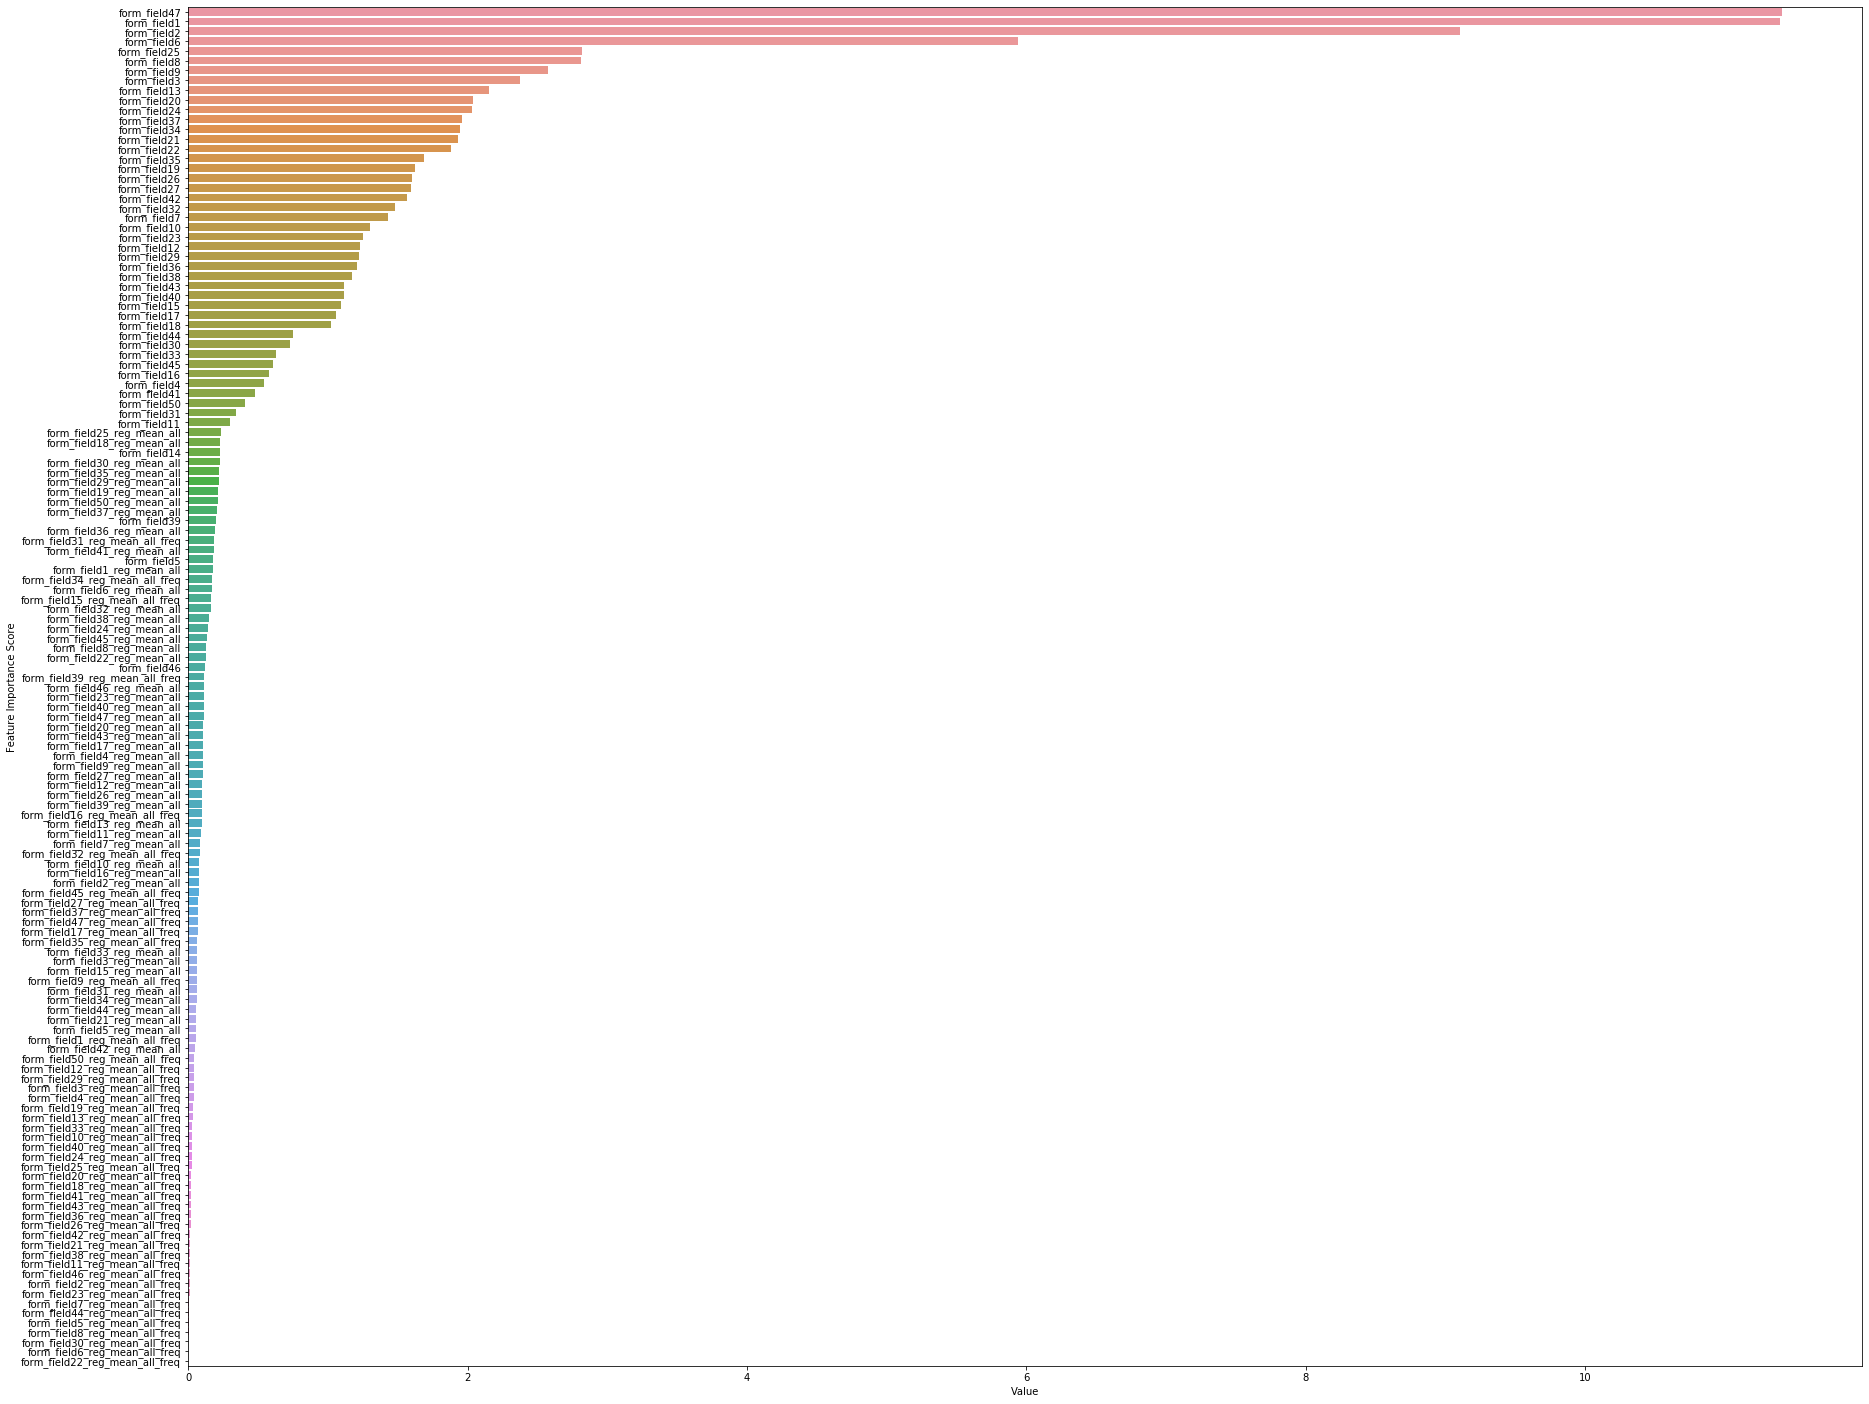

0.8419204799132043 0.8730630816524704 0.0045763399297769495


In [113]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370)

func_= func(train, target, test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

## **MODEL 2 - XGBOOST **

================================Fold1====================================
[22:58:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74605
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.80018
[2]	validation_0-auc:0.81941
[3]	validation_0-auc:0.82576
[4]	validation_0-auc:0.82755
[5]	validation_0-auc:0.82925
[6]	validation_0-auc:0.83236
[7]	validation_0-auc:0.83274
[8]	validation_0-auc:0.83382
[9]	validation_0-auc:0.83364
[10]	validation_0-auc:0.83302
[11]	validation_0-auc:0.83352
[12]	validation_0-auc:0.83418
[13]	validation_0-auc:0.83427
[14]	validation_0-auc:0.83411
[15]	validation_0-auc:0.83455
[16]

[34]	validation_0-auc:0.81822
[35]	validation_0-auc:0.81849
[36]	validation_0-auc:0.81865
[37]	validation_0-auc:0.81851
[38]	validation_0-auc:0.81810
[39]	validation_0-auc:0.81781
[40]	validation_0-auc:0.81766
[41]	validation_0-auc:0.81775
[42]	validation_0-auc:0.81794
[43]	validation_0-auc:0.81752
Stopping. Best iteration:
[13]	validation_0-auc:0.82220


Validation scores 0.8221979150321119 0.3831646272755781
Training scores 0.8665743135377655 0.33880006808127583
================================Fold5====================================
[22:59:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.70897
Will train until validation_0-auc hasn't

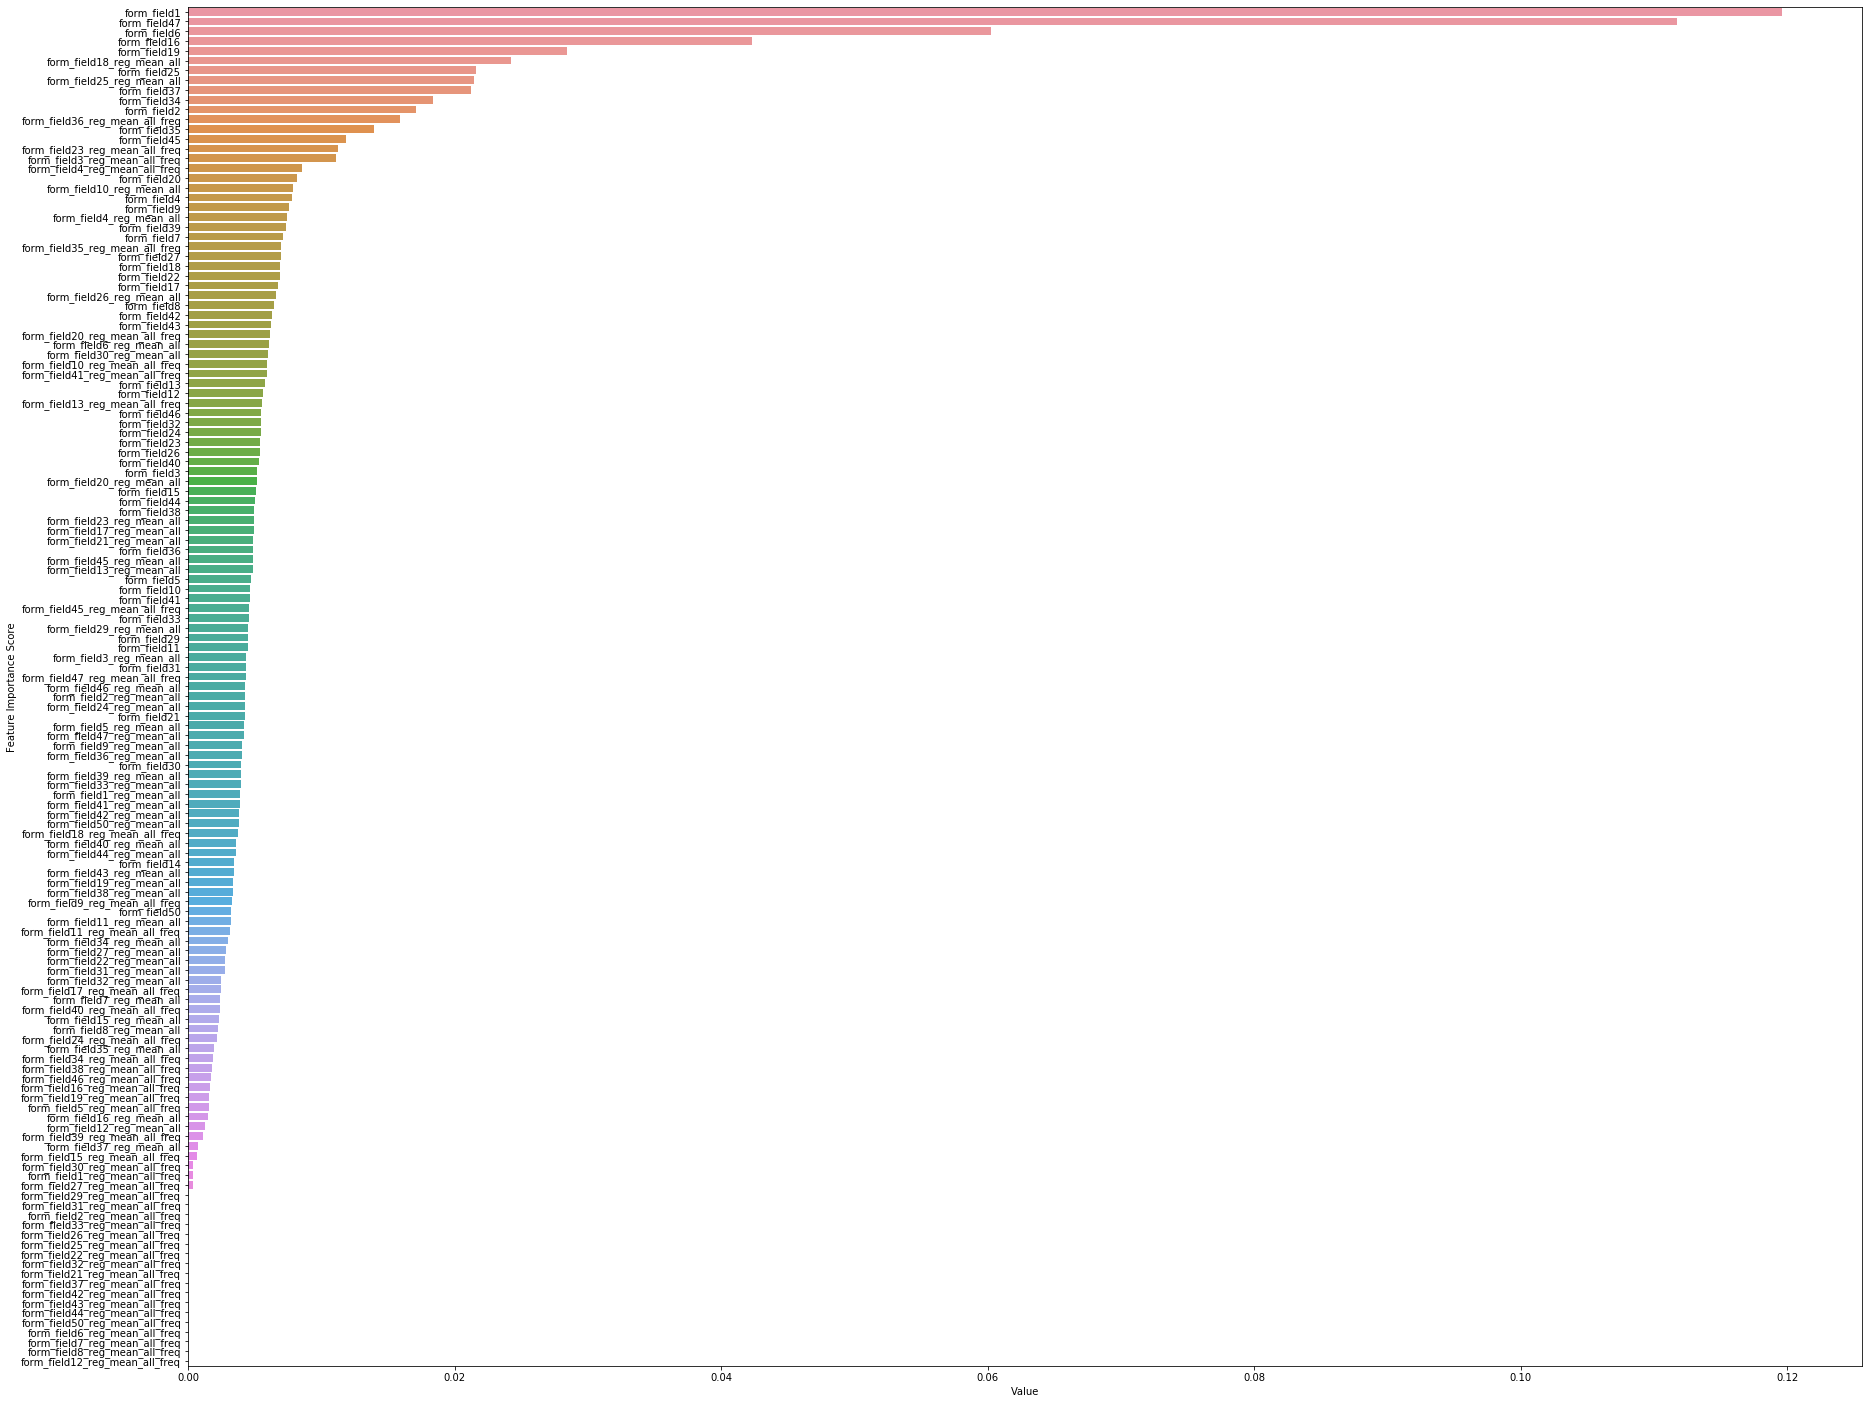

0.8328252741131357 0.874261083113249 0.0053349427969691604


In [114]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8) #, tree_method='gpu_hist') #, gpu_id=0)

func_= func(train, target, test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

## **MODEL 3 - LGBM **

================================Fold1====================================
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0004912993970392775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004912993970392775
[LightGBM] [Warning] bagging_fraction is set=0.9540416539312312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9540416539312312
[LightGBM] [Warning] lambda_l2 is set=9.424350138808432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.424350138808432
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's auc: 0.809333
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.81333
[3]	valid_0's auc: 0.815154
[4]	valid_0's auc: 0.817835
[5]	valid_0's auc: 0.8207
[6]	valid_0's auc: 0.821904
[7]	valid_0's auc: 0.823879
[8]	valid_0's auc: 0.8

[1]	valid_0's auc: 0.814318
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.817489
[3]	valid_0's auc: 0.819983
[4]	valid_0's auc: 0.823066
[5]	valid_0's auc: 0.824537
[6]	valid_0's auc: 0.827063
[7]	valid_0's auc: 0.828021
[8]	valid_0's auc: 0.828433
[9]	valid_0's auc: 0.829491
[10]	valid_0's auc: 0.83128
[11]	valid_0's auc: 0.831902
[12]	valid_0's auc: 0.833446
[13]	valid_0's auc: 0.834051
[14]	valid_0's auc: 0.834479
[15]	valid_0's auc: 0.835298
[16]	valid_0's auc: 0.835692
[17]	valid_0's auc: 0.835789
[18]	valid_0's auc: 0.836496
[19]	valid_0's auc: 0.836981
[20]	valid_0's auc: 0.837184
[21]	valid_0's auc: 0.837493
[22]	valid_0's auc: 0.837899
[23]	valid_0's auc: 0.837987
[24]	valid_0's auc: 0.838278
[25]	valid_0's auc: 0.83843
[26]	valid_0's auc: 0.838649
[27]	valid_0's auc: 0.83904
[28]	valid_0's auc: 0.839372
[29]	valid_0's auc: 0.839715
[30]	valid_0's auc: 0.839913
[31]	valid_0's auc: 0.840012
[32]	valid_0's auc: 0.840507
[33]	valid_0's auc: 0.8

[1]	valid_0's auc: 0.806649
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.808459
[3]	valid_0's auc: 0.818245
[4]	valid_0's auc: 0.819952
[5]	valid_0's auc: 0.823137
[6]	valid_0's auc: 0.825305
[7]	valid_0's auc: 0.82654
[8]	valid_0's auc: 0.827833
[9]	valid_0's auc: 0.828161
[10]	valid_0's auc: 0.829509
[11]	valid_0's auc: 0.830671
[12]	valid_0's auc: 0.83131
[13]	valid_0's auc: 0.832258
[14]	valid_0's auc: 0.832663
[15]	valid_0's auc: 0.833752
[16]	valid_0's auc: 0.834386
[17]	valid_0's auc: 0.834855
[18]	valid_0's auc: 0.835239
[19]	valid_0's auc: 0.835496
[20]	valid_0's auc: 0.835886
[21]	valid_0's auc: 0.836216
[22]	valid_0's auc: 0.836628
[23]	valid_0's auc: 0.836899
[24]	valid_0's auc: 0.837301
[25]	valid_0's auc: 0.83753
[26]	valid_0's auc: 0.837818
[27]	valid_0's auc: 0.838172
[28]	valid_0's auc: 0.838348
[29]	valid_0's auc: 0.838414
[30]	valid_0's auc: 0.838519
[31]	valid_0's auc: 0.83885
[32]	valid_0's auc: 0.839033
[33]	valid_0's auc: 0.83

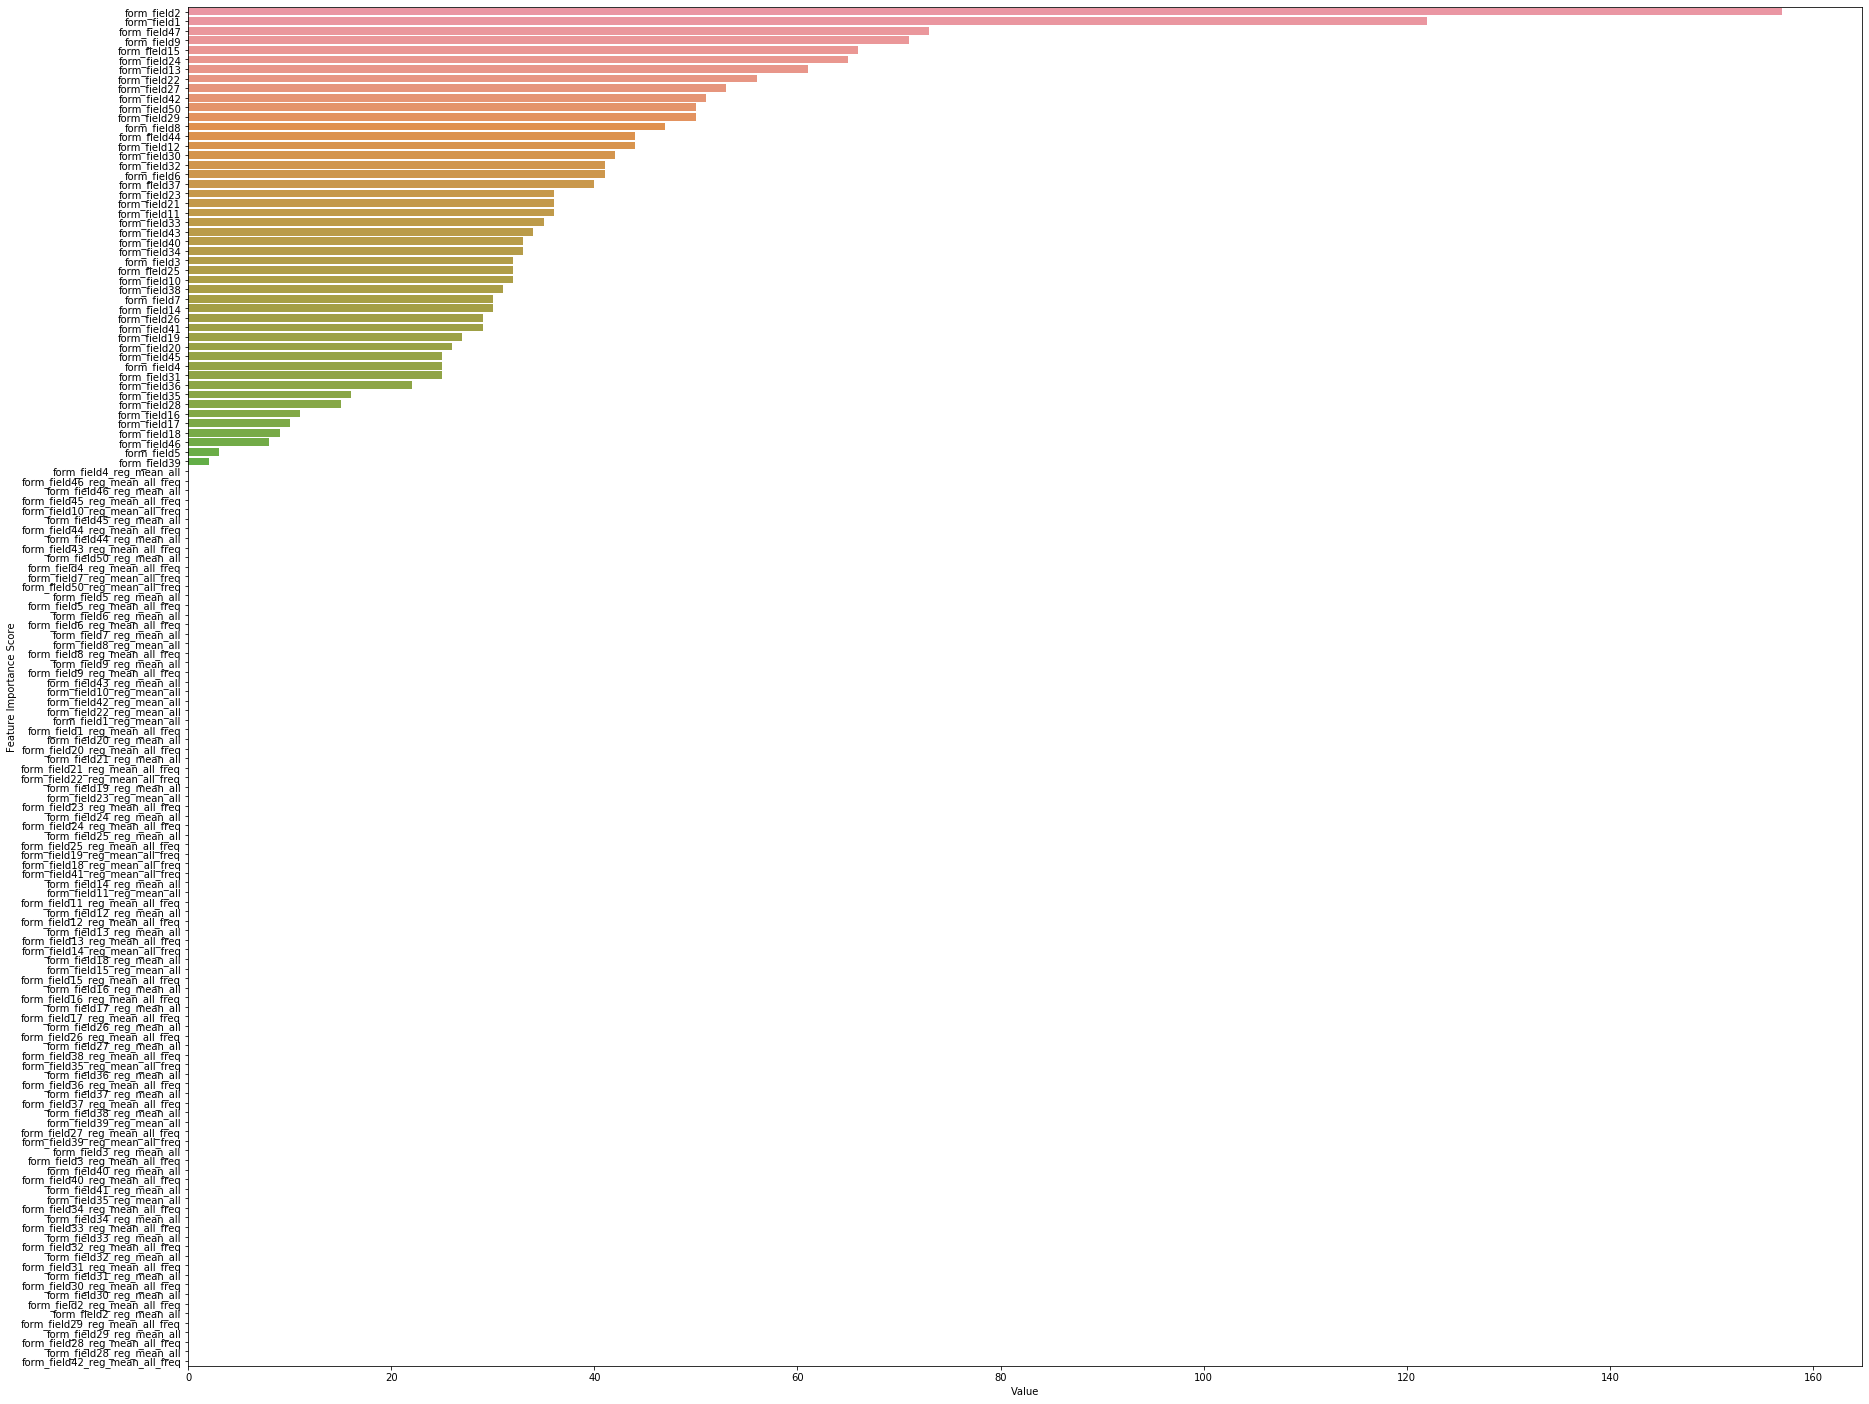

0.8391684473425223 0.8790532267568937 0.004972395560329231


In [143]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(train, target, test, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

## **STACKING AND BLENDING **

### **STACKING**

To stack, we use a simple algorithm as a meta-learner(Linear Regression) to finetune our predictions. We train this algorithm with the predictions of validation sets from all algorithms and use to produce the final predictions with the combination of the test set predictions from all algorithms.

In [41]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso

In [17]:
# stacking [based on line of best fit between the three models]

from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p3))
stack_p = np.column_stack((test_p1, test_p2, test_p3))
predict = LinearRegression().fit(stack, target).predict(stack_p)

### **BLENDING BASED ON WEIGHTED AVERAGE**

##### **FACTOR DETERMINATION FOR WEIGHTED AVERAGE**

In [95]:
a = 0.8391756698799799
b = 0.8323990321219684
c = 0.8406174341420783

i = a/(a+b+c)
j = b/(a+b+c)
k = c/(a+b+c)

print(i , j, k)
i + j + k

new_factor_1 = i
new_factor_2 = j
new_factor_3 = k

#print(new_factor_1,new_factor_2,new_factor_3)

fifth_predict = ((catboost_pred * new_factor_3) + (xgboost_pred * new_factor_2) + (lgbm_pred* new_factor_1))
sixth_predict = ((catboost_pred * 0.65) + (xgboost_pred * 0.15) + (lgbm_pred* 0.20))
seventh_predict = ((catboost_pred * 0.45) + (xgboost_pred * 0.15) + (lgbm_pred* 0.40))
eight_predict = ((catboost_pred * new_factor_3) + (xgboost_pred * new_factor_2) + (lgbm_pred* new_factor_1))
ninth_predict = ((catboost_pred * 0.336) + (xgboost_pred * 0.330) + (lgbm_pred* 0.334))
tenth_predict = ((catboost_pred * 0.338) + (xgboost_pred * 0.328) + (lgbm_pred* 0.334))
eleventh_predict = ((catboost_pred * 0.342) + (xgboost_pred * 0.323) + (lgbm_pred* 0.335))
twelfth_predict = ((catboost_pred * 0.352) + (xgboost_pred * 0.308) + (lgbm_pred* 0.340))
thirteenth_predict = ((catboost_pred * 0.387) + (xgboost_pred * 0.250) + (lgbm_pred* 0.363))
fourteenth_predict = ((catboost_pred * 0.366) + (xgboost_pred * 0.290) + (lgbm_pred* 0.344))
fifteenth_predict = ((catboost_pred * 0.376) + (xgboost_pred * 0.272) + (lgbm_pred* 0.352))



0.3340411976482157 0.3313436978588831 0.33461510449290127


####  *First Iteration*

In [13]:
# baseline prediction [based on the data without any feature engineering] 

cat1 = test_p1
xg1 = test_p2
lgbm1 = test_p3

####  *Second Iteration*

In [18]:
# prediction is based on [drop form_field 28]

cat = test_p1
xg = test_p2
lgbm = test_p3

sixteenth_predict = ((cat * 0.366) + (xg * 0.290) + (lgbm * 0.344))
seventeenth_predict = ((cat * 0.310) + (xg * 0.366) + (lgbm * 0.324))


eighteenth_predict = ((cat * 0.300) + (xg * 0.376) + (lgbm * 0.324))

fourteenth_predict = ((catboost_pred * 0.366) + (xgboost_pred * 0.290) + (lgbm_pred* 0.344))
fifteenth_predict = ((catboost_pred * 0.376) + (xgboost_pred * 0.272) + (lgbm_pred* 0.352))

nineteenth_predict = ((catboost_pred * 0.370) + (xgboost_pred * 0.280) + (lgbm_pred* 0.350)


####  *Third Iteration*

In [21]:
# prediction is based on [drop form_field 33]

catboost_pred = test_p1
xgboost_pred = test_p2
lgbm_pred = test_p3


predict = ((catboost_pred * 0.32) + (xgboost_pred * 0.34) + (lgbm_pred* 0.34))

second_predict = ((catboost_pred * 0.3234225) + (xgboost_pred * 0.3516385) + (lgbm_pred* 0.3249395))

####  *Fourth Iteration*

In [29]:
# prediction is based on [drop form_field 28, include max/min]

cat2 = test_p1
xg2 = test_p2
lgbm2 = test_p3

In [32]:
twentyfirst_predict = ((cat2 * 0.369) + (xg1 * 0.285) + (lgbm1 * 0.347))

In [35]:
twentysecond_predict = ((cat2 * 0.369) + (xg1 * 0.285) + (lgbm2 * 0.347))

In [36]:
third_predict = ((catboost_pred * 0.32) + (xgboost_pred * 0.36) + (lgbm_pred* 0.32))

In [40]:
summation = (0.86474718629) + (0.86968222448) + (0.87839995615)
summation

2.61282936692

In [41]:
add = 0.03607142857142882 + 0.03598089700996683 + 0.03639169435215972

In [45]:
a = 0.03607142857142882/add
b = 0.03598089700996683/add
c = 0.03639169435215972/add
print(a, b, c )

0.3326271803049177 0.3317923573103676 0.3355804623847146


In [46]:
a+b+c

0.9999999999999999

####  *Fifth Iteration*

In [71]:
# prediction is based on [drop form_field 48, 49] 

cat5 = test_p1
xg5 = test_p2
lgbm5 = test_p3------------------> # best lgbm based on leaderboard result



In [82]:
twentyfourth_predict = ((test2_cat1 * 0.372) + (test2_xg1 * 0.285) + (test2_lgbm1 * 0.348))

####  *Sixth Iteration*

In [87]:
# prediction is based on [drop form_field 48, 49 and 33,  group by form_field47] 

cat6 = test_p1
xg6 = test_p2-------------------> # best xgboost based on leaderboard result
lgbm6 = test_p3


In [88]:
twentyfifth_predict = ((test_p1 * 0.369) + (test_p2 * 0.285) + (test_p3 * 0.347))

In [93]:
twentysixth_predict = ((cat2 * 0.375) + (xg1 * 0.285) + (lgbm2 * 0.350))

In [99]:
twentyeight_predict = ((cat2 * 0.377) + (xg1 * 0.285) + (lgbm2 * 0.351))


####  *Seventh Iteration*

In [118]:
# prediction is based on [some important features selected from the features importance plots]

test3_cat1 = test_p1
test3_xg1 = test_p2
test3_lgbm1 = test_p3


In [124]:
twentyninth_predict = ((test3_cat1 * 0.375) + (xg1 * 0.285) + (lgbm2 * 0.350))

twentyninth_predict = ((test3_cat1 * 0.366) + (xg1 * 0.290) + (lgbm2 * 0.344))

####  *eighth Iteration*

In [160]:
# prediction is based on [drop form_field 48 and 49, group_by form field 14]

cat4 = test_p1------------------------> # best catboost based on leaderboard result
xg4 = test_p2
lgbm4 = test_p3


In [161]:
thirtieth_predict = ((cat4 * 0.375) + (xg1 * 0.285) + (lgbm2 * 0.350))


# Best Blend gave L.B score of 0.844961

_40_predict = ((cat4 * 0.381) + (xg6 * 0.282) + (lgbm5 * 0.352))

### **SUBMISSION**

In [145]:
submission['default_status'] = _40_predict

In [146]:
submission.to_csv('C:/Users/user/Desktop/1.coding_datascience/70 days machine learning/boothcamp qualification/submit/_40_predict.csv', index= False)

**FURTHER IMPROVEMENTS**
*   Feauture selection (Backward Elimination).
*   Better feature engineering(missing values)
*   Outlier handling
*   Train the different models on different random_seeds so as not to overfit a paticular seed
*   Add different features to different models, etc








